In [1]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

Global seed set to 0
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [4]:
st = time.time()

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
# url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
# output = 'pbmc.h5ad'
# gdown.download(url, output, quiet=False)

In [7]:
adata = sc.read('pbmc.h5ad')
# adata = sc.pp.subsample(adata, fraction=None, n_obs=5000, random_state=0, copy=True)

In [8]:
adata.X = adata.layers["counts"].copy()

In [9]:
condition_key = 'batch'
target_conditions = ['10X']

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [10]:
target_conditions = ["10X"]
removed_dataset = ['10X', 'Villani']
removed_viallni = ['Villani']
adata_villani_removed = adata[~adata.obs.study.isin(removed_viallni)].copy()
source_adata = adata_villani_removed[adata_villani_removed.obs.study.isin(['Freytag'])].copy()
source_conditions = source_adata.obs[condition_key].unique().tolist()
print(source_adata, source_conditions)
print(adata_villani_removed.obs['batch'])

AnnData object with n_obs × n_vars = 3347 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts' ['Freytag']
index
AAACCTGCAGCGAACA-1-Oetjen_A                Oetjen_A
AAACCTGCATGTCCTC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGACTGC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGCTTCT-1-Oetjen_A                Oetjen_A
AAACCTGTCCCGACTT-1-Oetjen_A                Oetjen_A
                                          ...      
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCATCATTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTCGCTTG-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTGTCTCG-1-Sun_sample4_TC    Sun_sample4_TC
Name: batch, Length: 32484, dtype: category
Categories (9, object): ['10X', 'Freytag', 'Oetjen_A', 'Oetjen_P', ..., 'Sun_sample1_CS', 'Sun_sample2_KC', 'Sun_sample3_

In [11]:
adata_tasks = adata_villani_removed[~adata_villani_removed.obs.study.isin(target_conditions)].copy()
adata_tasks_obs = adata_tasks.obs['batch']
tasks_list = list(set(adata_tasks_obs))
tasks_list

['Oetjen_A',
 'Oetjen_U',
 'Sun_sample2_KC',
 'Sun_sample4_TC',
 'Oetjen_P',
 'Sun_sample3_TB',
 'Freytag',
 'Sun_sample1_CS']

In [12]:
source_adata.raw = source_adata

In [13]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [14]:
sc.pp.normalize_total(source_adata)

In [15]:
sc.pp.log1p(source_adata)

In [16]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [17]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

In [18]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [19]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [20]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=0,
    learning_approach='latent replay',
)

latent replay is happening!
 |█████---------------| 25.0%  - val_loss: 445.9166361491 - val_recon_loss: 442.0112101237 - val_kl_loss: 6.2990570068 - val_mmd_loss: 0.00000000000
ADJUSTED LR
 |█████---------------| 26.4%  - val_loss: 440.9086608887 - val_recon_loss: 436.8016459147 - val_kl_loss: 6.2702450752 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 110


In [21]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
adata_latent.obs["batch"] = source_adata.obs["batch"].tolist()

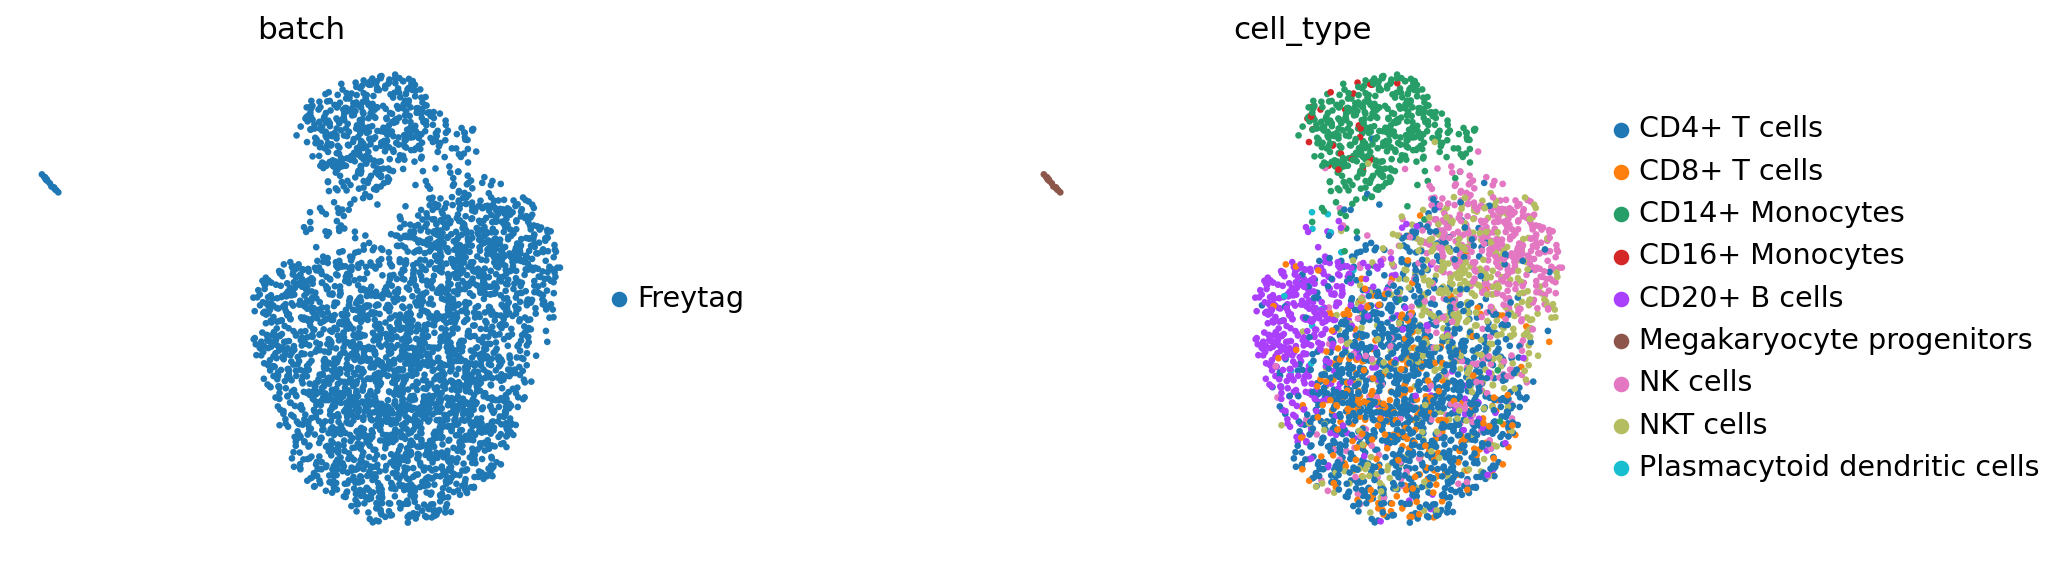

In [22]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [23]:
ref_path = 'reference_model_PBMC/'
trvae.save(ref_path, overwrite=True)

In [26]:
list_task_i = []
for ID, task in enumerate(tasks_list, start=1): #adata_tasks[1:] if you wanna skip the first item
    print(ID, task)
    task_i = adata_tasks[adata_tasks.obs['batch'].isin([task])]
    task_i = task_i[:, source_adata.var_names]
    new_trvae = sca.models.TRVAE.load_query_data(adata=task_i,
                                                 learning_approach = 'latent replay',
                                                 model=ref_path)
    new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=ID,
    weight_decay=0,
    learning_approach = 'latent replay'
    )
    
    ref_path = 'reference_model_PBMC/'
    new_trvae.save(ref_path, overwrite=True)
    list_task_i.append(task_i)

1 Oetjen_A

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

latent replay is happening!
 |█-------------------| 8.8%  - val_loss: 704.8927001953 - val_recon_loss: 699.7693684896 - val_kl_loss: 23.8294499715 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██------------------| 10.2%  - val_loss: 743.2176310221 - val_recon_loss: 737.3413492839 - val_kl_loss: 23.5050468445 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 29
2 Oetjen_U

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Laye

In [30]:
adata_full = source_adata.concatenate(list_task_i, batch_key="ref_query")
adata_full

AnnData object with n_obs × n_vars = 25104 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'trvae_size_factors', 'trvae_labeled', 'ref_query'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    layers: 'counts'

In [31]:
full_latent = sc.AnnData(new_trvae.get_latent(adata_full.X, adata_full.obs[condition_key]))
full_latent.obs['cell_type'] = adata_full.obs["final_annotation"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()

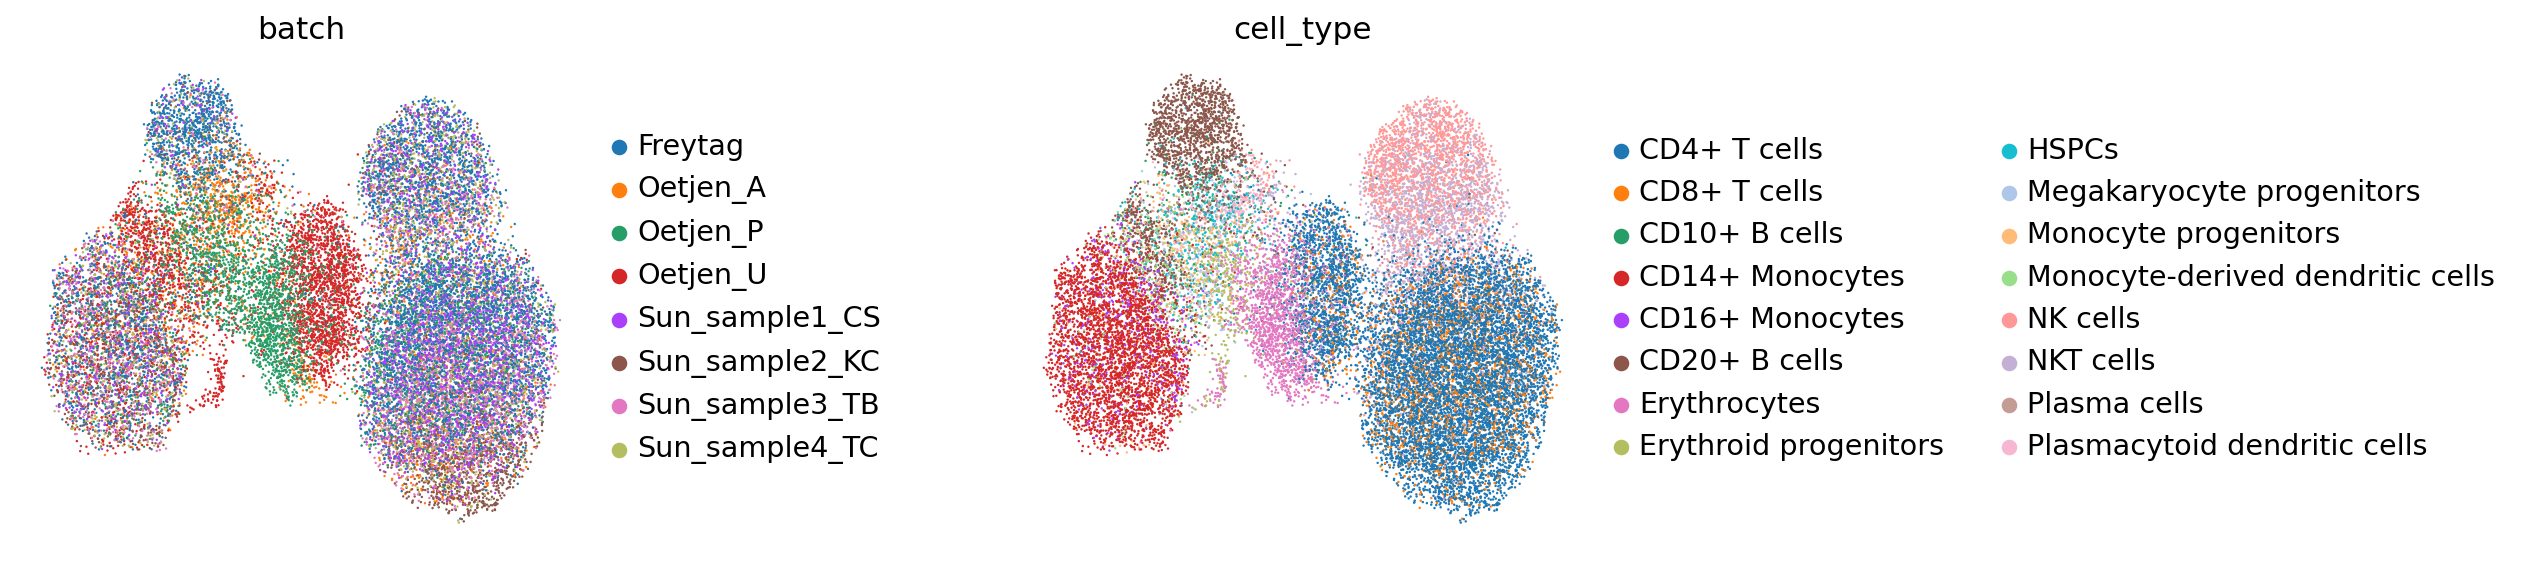

In [32]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [33]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 03:44:54


In [34]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_LR_1=scib.metrics.graph_connectivity(full_latent, 'batch')
Batch_corr_graph_conn_LR_1

0.5849331122572639

In [35]:
sc.tl.umap(full_latent)
Batch_corr_ASW_LR_1=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_LR_1

mean silhouette per group:                                   silhouette_score
group                                             
CD10+ B cells                             0.766025
CD14+ Monocytes                           0.919225
CD16+ Monocytes                           0.871957
CD20+ B cells                             0.801311
CD4+ T cells                              0.777794
CD8+ T cells                              0.808933
Erythrocytes                              0.692318
Erythroid progenitors                     0.714003
HSPCs                                     0.817330
Megakaryocyte progenitors                 0.788670
Monocyte progenitors                      0.777502
Monocyte-derived dendritic cells          0.866221
NK cells                                  0.817895
NKT cells                                 0.800794
Plasma cells                              0.803104
Plasmacytoid dendritic cells              0.782130


0.8003258490275433

In [36]:
Bio_cons_ASW_LR_1=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_LR_1

0.4697665423154831

In [37]:
isolated_labels_LR_1=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_LR_1

isolated labels: no more than 3 batches per label


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


CD10+ B cells: 0.11718131433095802


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Erythrocytes: 0.653884297520661


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Erythroid progenitors: 0.32054176072234764


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


HSPCs: 0.22942643391521195


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Monocyte progenitors: 0.17040951122853368


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Plasma cells: 0.06402048655569784


0.2592439673789017

In [38]:
pcr_LR_1=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_LR_1

0.6530582954689051